# Brain Tumor Image DataSet : Semantic Segmentation
https://www.kaggle.com/datasets/pkdarabi/brain-tumor-image-dataset-semantic-segmentation/code\
Code from:\
https://www.kaggle.com/code/amrabdellatif/brain-tumor-image-dataset-semantic-segmentation\
https://www.kaggle.com/code/mathieuduverne/brain-segmentation-detectron2-map-50-77-9

---
This dataset seems only got tumor image with two class

In [1]:
from pycocotools.coco import COCO
from PIL import Image
from mat73 import loadmat
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import json, pickle
import os
import skimage.draw
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from tqdm import tqdm
from torchvision import transforms
from torchvision.utils import save_image
from torch.utils.data import Dataset, DataLoader
import numpy as np
import cv2 as cv

batch_size =32

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
transform = transforms.ToTensor()

# tranform in train might help? Move
# The predict m seems tend to be in the same zone
train_tfm = transforms.Compose([
    transforms.ToTensor(),  # Convert the image to a PyTorch tensor
    transforms.Resize(256),  # Resize the image to 256x256 pixels
    transforms.CenterCrop(224),  # Crop the image to 224x224 pixels from the center
    # transforms.RandomHorizontalFlip(p=0.5),
    # transforms.RandomResizedCrop(size=(224, 224), antialias=True),
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize the image
])
test_tfm = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(256),
    transforms.CenterCrop(224),  # Crop the image to 224x224 pixels from the center
])

mode = "train"

class Dataset_(Dataset):
    def __init__(self, data):
        self.img = data[0]  # Assuming 'data' is a list of tuples (images, labels)
        self.label = data[1]
        self.tumormask = data[2]

    def __len__(self):
        return len(self.img)

    def __getitem__(self, idx):
        return self.img[idx], self.label[idx], self.tumormask[idx]

## Datasets


In [2]:
%cd data/ 
"""
!kaggle datasets download -d navoneel/brain-mri-images-for-brain-tumor-detection
!unzip brain-mri-images-for-brain-tumor-detection.zip
!rm brain-mri-images-for-brain-tumor-detection.zip
!rm -r no yes

!kaggle datasets download -d pkdarabi/brain-tumor-image-dataset-semantic-segmentation
!unzip brain-tumor-image-dataset-semantic-segmentation.zip
!rm brain-tumor-image-dataset-semantic-segmentation.zip

!kaggle datasets download -d vishwapatel10/brain-tumor-dataset
!unzip brain-tumor-dataset.zip
!rm brain-tumor-dataset.zip
!kaggle datasets download -d ashkhagan/figshare-brain-tumor-dataset
!unzip figshare-brain-tumor-dataset.zip
!rm figshare-brain-tumor-dataset.zip
"""
%cd ..

/home/jacob/projects/Computer_Vision/Brain Tumor/BrainTumor/data
/home/jacob/projects/Computer_Vision/Brain Tumor/BrainTumor


dict_keys(['PID', 'image', 'label', 'tumorBorder', 'tumorMask'])
(512, 512)


/home/jacob/anaconda3/envs/mlntu/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


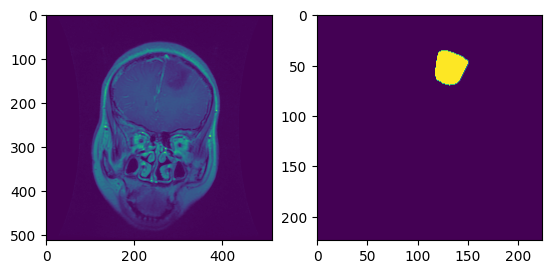

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DATA_PATH = './data/dataset'
files = os.listdir(DATA_PATH)
for i, file in enumerate(files):
    file_path = os.path.join(DATA_PATH, file)
    data = loadmat(file_path)
    image = data['cjdata']['image']
    break
print(data['cjdata'].keys())
# print(data['cjdata'])
print(image.shape)
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.subplot(1, 2, 2)
plt.imshow(train_tfm(data['cjdata']['tumorMask']).permute(1, 2, 0))
plt.show()

In [7]:
def to_image(img):    
    plt.imshow(img)
    plt.savefig('temp/image.jpg', bbox_inches='tight', dpi=300)
    return Image.open('temp/image.jpg')

def get_index(lengths):
    indices = np.arange(lengths)
    print(len(indices))
    train_indices = np.random.choice(indices, size = np.floor(lengths*0.8).astype(int), replace=False)
    indices = [x for x in indices if x not in train_indices]
    valid_indices = np.random.choice(indices, size = np.floor(lengths*0.1).astype(int), replace=False)
    indices = [x for x in indices if x not in valid_indices]
    test_indices = indices
    print(
        len(train_indices), len(valid_indices), len(test_indices), 
        len(train_indices) + len(valid_indices) + len(test_indices))
    return train_indices, valid_indices, test_indices

def data(indices, files, train = True, device = 'cuda'):
    imgs, pids, labels, tumorborders, tumormasks = [], [], [], [], []
    if train == True:
        print('Use train transform')
        transform = train_tfm
    else:
        print('Use test transform')
        transform = test_tfm
    for index, file in tqdm(enumerate(files)):
        if index not in indices:
            continue
        file_path = os.path.join(DATA_PATH, file)
        try:
            data = loadmat(file_path)['cjdata']
        except:
            print(file_path)
        """
        img = to_image(data['image'])
        transform(img)
        """
        # ############################
        # TODO:
        # Need to know how to change tumorborder and tumormask when size change
        imgs.append(transform(data['image']).to(device)) 
        pids.append(data['PID'])
        labels.append(torch.tensor(data['label']).reshape(-1).to(device))
        tumorborders.append(torch.tensor(data['tumorBorder']))
        tumormasks.append(transform(data['tumorMask']).to(device))
    data = [imgs, labels, tumormasks]
    return data

In [ ]:
train_indices, valid_indices, test_indices = get_index(len(files))
train_data = data(train_indices, files)
valid_data = data(valid_indices, files, False)
test_data = data(test_indices, files, False)

train_data_cpu = data(train_indices, files, device='cpu')

In [ ]:
# Train
"""
imgs_, labels_, tumormasks_
"""
# Train
dataset = Dataset_(train_data)
with open('temp/traindataset.pk', 'wb') as f:
    pickle.dump(dataset, f)
# Valid
dataset = Dataset_(valid_data)
with open('temp/validdataset.pk', 'wb') as f:
    pickle.dump(dataset, f)
# Test
dataset = Dataset_(test_data)
with open('temp/testdataset.pk', 'wb') as f:
    pickle.dump(dataset, f)

# Train cpu
dataset = Dataset_(train_data_cpu)
with open('temp/traindataset_cpu.pk', 'wb') as f:
    pickle.dump(dataset, f)


In [ ]:
"""for img, label, mask in trainloader:
    print(img)
    break"""

'for img, label, mask in trainloader:\n    print(img)\n    break'

In [ ]:
"""
import torch
for i, l, m in trainloader:
    break
plt.imshow(i[0].to(dtype=torch.float32).repeat(3, 1, 1).permute(1, 2, 0).cpu())
plt.imshow(i[0].permute(1, 2, 0).cpu())
"""